In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from PIL import Image

import torch
import torchvision as tv
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from collections import OrderedDict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay, fbeta_score

In [2]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: A100-SXM4-40GB
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     39.6 GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def f_beta(precision,recall,B):
    try:
        out = (1+B**(2))*(precision*recall) / (B**(2) * precision +recall)
        return out
    except:
        return 0
    
    

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, dataset):
        """data is assumed to be an array of tuples where each tuple contains the path to image and the class name of the image"""      
        self.img_paths = data
        self.dataset = dataset

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.img_paths)
        

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = img_path.split("-")[1]
        label = str_to_number[label]
        img = Image.open(os.path.join("drive/MyDrive/CS464_project/part2images", self.dataset,img_path)).convert("RGB")
        convert_tensor = tv.transforms.ToTensor()
        img_tensor = convert_tensor(img)
        return img_tensor, label


In [6]:
number_to_str = {0:"normal", 1:"benign", 2:"malignant"}
str_to_number = {"normal":0, "benign":1, "malignant":2}

In [7]:
path = "drive/MyDrive/CS464_project/part2images"
train_paths = os.listdir(os.path.join(path,"train"))
val_paths = os.listdir(os.path.join(path,"val"))
test_paths = os.listdir(os.path.join(path,"test"))



# Normal vs Bening vs Malignant

In [24]:
train_dataset, val_dataset, test_dataset = CustomDataset(train_paths, "train"), CustomDataset(val_paths, "val"), CustomDataset(test_paths, "test")

In [25]:
model = tv.models.resnet50(pretrained = True)
for param in model.parameters():
   param.requires_grad = False
num_input = model.fc.in_features

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
max_epoch = 100
train_batch = 256
momentum = 0.99
learning_rate = 6e-3
weight_decay = 7e-4


In [27]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_input,1024)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(1024,3)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.fc = fc
model_Res = model.to(device)


optimizer = torch.optim.SGD(model.fc.parameters(), lr= learning_rate, momentum = momentum, weight_decay = weight_decay)
lossFunction = nn.NLLLoss()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f2_score":[]}



best_score = 0
best_params = None

In [28]:
trainDataLoader = DataLoader(train_dataset, shuffle=True, batch_size = train_batch)
valDataLoader = DataLoader(val_dataset, batch_size = len(val_dataset))
testDataLoader = DataLoader(test_dataset, batch_size = len(test_dataset))




for e in range(0, max_epoch):
    

    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    t1 = time.time()
    for x, y in trainDataLoader:

        x = x.to(device) 
        y = y.to(device)

        log_probs = model(x)
        loss = lossFunction(log_probs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss
        predictions = log_probs.argmax(1)
        trainCorrect += (predictions == y).type(torch.float).sum().item()
    t2 = time.time()
	
    with torch.no_grad():

        model.eval()

        for x, y in valDataLoader:

            x = x.to(device) 
            y = y.to(device)

            log_probs = model(x)
            totalValLoss += lossFunction(log_probs, y)

            predictions = log_probs.argmax(1)

            valCorrect += (predictions == y).type(torch.float).sum().item()

    report = classification_report(y.cpu().detach().numpy(),predictions.cpu().detach().numpy(), output_dict = True, zero_division = 0)
    f2_score = fbeta_score(y.cpu().detach().numpy(),predictions.cpu().detach().numpy(),beta = 2, average = "macro")

    if best_score <= f2_score:
        best_params = copy.deepcopy(model.state_dict())
        best_score = f2_score

    avgTrainLoss = totalTrainLoss / len(trainDataLoader.dataset)
    avgValLoss = totalValLoss / len(valDataLoader.dataset)

    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    history["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    history["train_acc"].append(trainCorrect)
    history["val_loss"].append(avgValLoss.cpu().detach().numpy())
    history["val_acc"].append(valCorrect)
    history["val_f2_score"].append(f2_score)

    print("Training: epoch {}/{}".format(e+1,max_epoch))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    print("f2-score on val set:{}".format(f2_score))
    print("Epoch completed in {:.4f} seconds\n".format(t2-t1))

Training: epoch 1/100
Train loss: 0.003457, Train accuracy: 0.6488
Val loss: 0.003237, Val accuracy: 0.8242
f2-score on val set:0.6080540524815268
Epoch completed in 13.7895 seconds

Training: epoch 2/100
Train loss: 0.001984, Train accuracy: 0.7693
Val loss: 0.003235, Val accuracy: 0.8000
f2-score on val set:0.609252495158718
Epoch completed in 13.6399 seconds

Training: epoch 3/100
Train loss: 0.001951, Train accuracy: 0.7654
Val loss: 0.006311, Val accuracy: 0.7758
f2-score on val set:0.6643821471109952
Epoch completed in 13.6387 seconds

Training: epoch 4/100
Train loss: 0.002130, Train accuracy: 0.7650
Val loss: 0.005742, Val accuracy: 0.7939
f2-score on val set:0.5871706392932398
Epoch completed in 13.6101 seconds

Training: epoch 5/100
Train loss: 0.001785, Train accuracy: 0.8069
Val loss: 0.002702, Val accuracy: 0.8545
f2-score on val set:0.6297380907285186
Epoch completed in 13.7220 seconds

Training: epoch 6/100
Train loss: 0.001591, Train accuracy: 0.8098
Val loss: 0.001569,

Text(0.5, 0, 'Epoch')

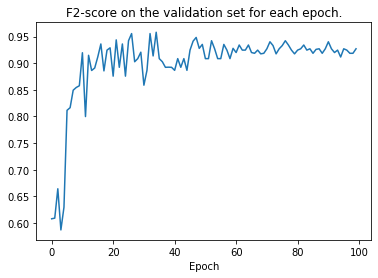

In [29]:
plt.plot(history["val_f2_score"])
plt.title("F2-score on the validation set for each epoch.")
plt.xlabel("Epoch")

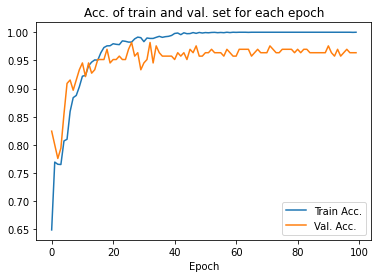

In [30]:
plt.plot(history["train_acc"])
plt.plot(history["val_acc"])
plt.xlabel("Epoch")
plt.title("Acc. of train and val. set for each epoch")
plt.legend(["Train Acc.", "Val. Acc."])

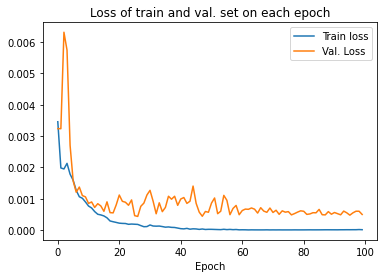

In [31]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.title("Loss of train and val. set on each epoch")
plt.legend(["Train loss", "Val. Loss"])


In [32]:
model.load_state_dict(best_params)

<All keys matched successfully>

In [33]:
totalTestLoss = 0
testCorrect = 0
with torch.no_grad():
    model.eval()

    for x, y in testDataLoader:

        x = x.to(device) 
        y = y.to(device)
        log_probs = model(x)

        predictions = log_probs.argmax(1)
        
        cm = confusion_matrix(y.cpu().detach().numpy(),predictions.cpu().detach().numpy())
        report = classification_report(y.cpu().detach().numpy(),predictions.cpu().detach().numpy(), output_dict = True)

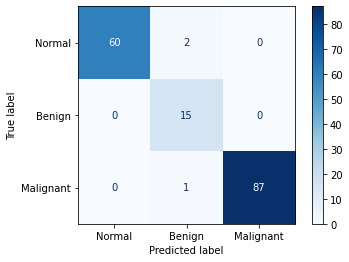

In [34]:
labels = ["Normal", "Benign", "Malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [38]:

macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f2_score = f2_score = fbeta_score(y.cpu().detach().numpy(),predictions.cpu().detach().numpy(),beta = 2, average = "macro")
acc = (cm [0,0]+cm[1,1] + cm[2,2]) / (np.sum(cm))

print("Macro precision:", macro_precision)
print("Macro recall:", macro_recall)
print("Macro f2-score :", macro_f2_score)
print("Accuracy:", acc)

Macro precision: 0.9444444444444445
Macro recall: 0.9854594330400782
Macro f2-score : 0.9754842727507875
Accuracy: 0.9818181818181818


In [36]:
pd.DataFrame(report)

,0,1,2,accuracy,macro avg,weighted avg
precision,1.000000,0.833333,1.000000,0.981818,0.944444,0.984848
recall,0.967742,1.000000,0.988636,0.981818,0.985459,0.981818
f1-score,0.983607,0.909091,0.994286,0.981818,0.962328,0.982528
support,62.000000,15.000000,88.000000,0.981818,165.000000,165.000000


# Bening vs Malignant


In [9]:
def precision(cm):
    try:
        return cm[1,1]/np.sum(cm[:,1])
    except:
        return 0
def recall(cm):
    try:
        return cm[1,1]/np.sum(cm[1,:])
    except:
        return 0

In [10]:
class CustomDataset(Dataset):
    def __init__(self, data, dataset):
        """data is assumed to be an array of tuples where each tuple contains the path to image and the class name of the image"""      
        self.img_paths = data
        self.dataset = dataset

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.img_paths)
        

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        label = img_path.split("-")[1]
        label = str_to_number2[label]
        img = Image.open(os.path.join("drive/MyDrive/CS464_project/part2images", self.dataset,img_path)).convert("RGB")
        convert_tensor = tv.transforms.ToTensor()
        img_tensor = convert_tensor(img)
        return img_tensor, label


In [11]:
number_to_str2 = {0:"benign", 1:"malignant"}
str_to_number2 = {"benign":0,"malignant":1}

In [12]:
train_paths = list(filter(lambda x: x.split("-")[1] != "normal", train_paths))
val_paths = list(filter(lambda x: x.split("-")[1] != "normal", val_paths))
test_paths = list(filter(lambda x: x.split("-")[1] != "normal", test_paths))



In [13]:
train_dataset, val_dataset, test_dataset = CustomDataset(train_paths, "train"), CustomDataset(val_paths, "val"), CustomDataset(test_paths, "test")

In [14]:
model = tv.models.resnet50(pretrained = True)
for param in model.parameters():
   param.requires_grad = False
num_input = model.fc.in_features

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
max_epoch = 10
train_batch = 256
momentum = 0.99
learning_rate = 6e-3
weight_decay = 5e-04


In [16]:
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_input,1024)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(1024,2)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.fc = fc
model_Res = model.to(device)


optimizer = torch.optim.SGD(model.fc.parameters(), lr= learning_rate, momentum = momentum, weight_decay = weight_decay)
lossFunction = nn.NLLLoss()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f2_score":[]}



best_score = 0
best_params = None

In [17]:
trainDataLoader = DataLoader(train_dataset, shuffle=True, batch_size = train_batch)
valDataLoader = DataLoader(val_dataset, batch_size = len(val_dataset))
testDataLoader = DataLoader(test_dataset, batch_size = len(test_dataset))

for e in range(0, max_epoch):
    

    model.train()

    totalTrainLoss = 0
    totalValLoss = 0

    trainCorrect = 0
    valCorrect = 0

    t1 = time.time()
    for x, y in trainDataLoader:

        x = x.to(device) 
        y = y.to(device)

        log_probs = model(x)
        loss = lossFunction(log_probs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalTrainLoss += loss
        predictions = log_probs.argmax(1)
        trainCorrect += (predictions == y).type(torch.float).sum().item()
    t2 = time.time()
	
    with torch.no_grad():

        model.eval()

        for x, y in valDataLoader:

            x = x.to(device) 
            y = y.to(device)

            log_probs = model(x)
            totalValLoss += lossFunction(log_probs, y)

            predictions = log_probs.argmax(1)

            valCorrect += (predictions == y).type(torch.float).sum().item()

    cm = confusion_matrix(predictions.cpu().detach().numpy(), y.cpu().detach().numpy())
    report = classification_report(y.cpu().detach().numpy(),predictions.cpu().detach().numpy()) 
    f2_score= f_beta(precision(cm), recall(cm),2) 

    if best_score <= f2_score:
        best_params = copy.deepcopy(model.state_dict())
        best_score = f2_score

    avgTrainLoss = totalTrainLoss / len(trainDataLoader.dataset)
    avgValLoss = totalValLoss / len(valDataLoader.dataset)

    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    history["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    history["train_acc"].append(trainCorrect)
    history["val_loss"].append(avgValLoss.cpu().detach().numpy())
    history["val_acc"].append(valCorrect)
    history["val_f2_score"].append(f2_score)

    print("Training: epoch {}/{}".format(e+1,max_epoch))
    print("Train loss: {:.4f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.4f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))
    print("f2-score on val set:{}".format(f2_score))
    print("Epoch completed in {:.4f} seconds\n".format(t2-t1))

Training: epoch 1/10
Train loss: 0.0024, Train accuracy: 0.6660
Val loss: 0.0039, Val accuracy: 0.9126
f2-score on val set:0.9489051094890509
Epoch completed in 93.7181 seconds

Training: epoch 2/10
Train loss: 0.0009, Train accuracy: 0.9271
Val loss: 0.0009, Val accuracy: 0.9903
f2-score on val set:0.9904534606205251
Epoch completed in 9.1695 seconds

Training: epoch 3/10
Train loss: 0.0005, Train accuracy: 0.9572
Val loss: 0.0009, Val accuracy: 0.9515
f2-score on val set:0.9732360097323602
Epoch completed in 9.2353 seconds

Training: epoch 4/10
Train loss: 0.0004, Train accuracy: 0.9687
Val loss: 0.0026, Val accuracy: 0.9223
f2-score on val set:0.9791122715404699
Epoch completed in 9.2701 seconds

Training: epoch 5/10
Train loss: 0.0005, Train accuracy: 0.9659
Val loss: 0.0042, Val accuracy: 0.9223
f2-score on val set:0.9791122715404699
Epoch completed in 9.1776 seconds

Training: epoch 6/10
Train loss: 0.0005, Train accuracy: 0.9674
Val loss: 0.0068, Val accuracy: 0.8932
f2-score on

Text(0.5, 0, 'Epoch')

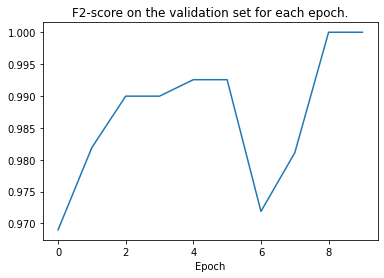

In [ ]:
plt.plot(history["val_f2_score"])
plt.title("F2-score on the validation set for each epoch.")
plt.xlabel("Epoch")

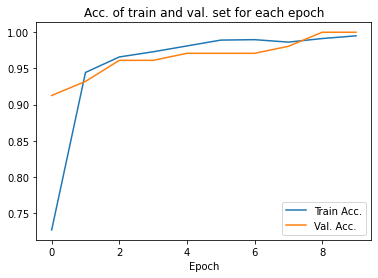

In [ ]:
plt.plot(history["train_acc"])
plt.plot(history["val_acc"])
plt.xlabel("Epoch")
plt.title("Acc. of train and val. set for each epoch")
plt.legend(["Train Acc.", "Val. Acc."])

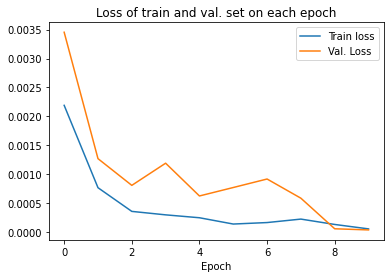

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.title("Loss of train and val. set on each epoch")
plt.legend(["Train loss", "Val. Loss"])


In [ ]:
totalTestLoss = 0
testCorrect = 0
with torch.no_grad():
    model.eval()

    for x, y in testDataLoader:

        x = x.to(device) 
        y = y.to(device)
        log_probs = model(x)

        predictions = log_probs.argmax(1)
        
        cm = confusion_matrix(y.cpu().detach().numpy(),predictions.cpu().detach().numpy())
        report = classification_report(y.cpu().detach().numpy(),predictions.cpu().detach().numpy(), output_dict = True)

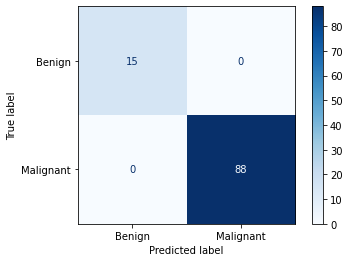

In [ ]:
labels = ["Benign", "Malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()